# Predicting citation style from the reference string
Dominika Tkaczyk

2.10.2018

In this notebook I build a classifier for predicting citation style based on the reference string.

In [1]:
import sys
sys.path.append('..')

%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from config import STYLES
from data_utils import add_noise, clean_data, read_ref_strings_data, remove_technical_parts
from evaluation import evaluate_cv
from features import get_features, get_tfidf_features, select_features_chi2, select_features_rf, tokens_to_classes
from random import randint, seed
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from statistics import mean

/home/dtkaczyk/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Read the data:

In [2]:
dataset = read_ref_strings_data('../data/ref_strings/')
print('Dataset size: {}'.format(dataset.shape[0]))
dataset.head()

Dataset size: 85000


,doi,string,style
0,10.1016/s0002-9394(14)70125-4,"[1]LEE, S.-H. and TSENG, S.C.G. 1997. Amniotic...",acm-sig-proceedings
1,10.1016/0920-9964(95)95073-i,"[1]Scheffer, R. et al. 1995. History of premor...",acm-sig-proceedings
2,10.1075/cilt.97.22vek,"[1]Vekerdi, J. 1993. 4. Word formation in Gips...",acm-sig-proceedings
3,10.1080/19761597.2013.810947,"[1]Kang, J. et al. 2013. Determinants of succe...",acm-sig-proceedings
4,10.1016/0378-1119(79)90090-8,"[1]Wickens, M.P. et al. 1979. Restriction map ...",acm-sig-proceedings


Get rid of null and short reference strings:

In [3]:
dataset = clean_data(dataset)
print('Dataset size: {}'.format(dataset.shape[0]))

Dataset size: 82834


 Let's see example entries for each style:

In [4]:
seed(102608026)
examples = dataset.groupby('style').nth(randint(0, 4999)).reset_index()
print('\n\n'.join(['{}\n{}'.format(s, t) for s, t in zip(examples['style'].tolist(), examples['string'].tolist())]))

acm-sig-proceedings
[1]Beckman, K.A. et al. 2004. Trends in Police Research: A Cross‐Sectional Analysis of the 2001 Literature. Police Practice and Research. 5, 2 (May 2004), 165–189.

american-chemical-society
(1) Davis, D. L. The Dictionary of Modern American Philosophers.

american-chemical-society-with-titles
(1) Yaster, M.; Benzon, H. T.; Anderson, T. A. “Houston, We Have a Problem!”Anesthesia & Analgesia 2017, 125, 1429–1431.

american-institute-of-physics
1 W. Zhang, L. Hong, and P.C. McGowan, Macromolecular Chemistry and Physics 215, 900 (2014).

american-sociological-association
O’Boyle, Michael F. P., and Peter M. W. Knijnenburg. 1999. International Journal of Parallel Programming 27(3):131–59. Retrieved

apa
Beckman, K. A., Wyckoff, L., Groff, E. R., & Beatty, P. D. (2004). Trends in Police Research: A Cross‐Sectional Analysis of the 2001 Literature. Police Practice and Research, 5(2), 165–189.

bmc-bioinformatics
1. Yaster M, Benzon HT, Anderson TA: “Houston, We Have a Prob

  It seems we have some remains from DOI stripping. We will remove those parts.

In [5]:
dataset['string'] = dataset['string'].apply(remove_technical_parts)

Reference strings generated automatically are also a bit too perfect. For example, all strings of american-chemical-society style are prefixed by "(1)". This prefix alone would be enough for the learning algorithm to assign a string to this class. On the other hand, we cannot expect all strings "in real life" to have a proper prefix (some tools/extractors might strip this).

I will also remove the names of the months from fragments such as "(Mar 1997)". They appear quite often in string automatically generated, but real reference string often omit months.

To make the dataset a bit less perfect, let's remove such fragments from (randomly chosen) half of the references:

In [6]:
seed(10)
dataset['string'] = dataset['string'].apply(add_noise)
dataset.head()

,doi,string,style
0,10.1016/s0002-9394(14)70125-4,"[1]LEE, S.-H. and TSENG, S.C.G. 1997. Amniotic...",acm-sig-proceedings
1,10.1016/0920-9964(95)95073-i,"[1]Scheffer, R. et al. 1995. History of premor...",acm-sig-proceedings
2,10.1075/cilt.97.22vek,"Vekerdi, J. 1993. 4. Word formation in Gipsy l...",acm-sig-proceedings
3,10.1080/19761597.2013.810947,"Kang, J. et al. 2013. Determinants of successf...",acm-sig-proceedings
4,10.1016/0378-1119(79)90090-8,"[1]Wickens, M.P. et al. 1979. Restriction map ...",acm-sig-proceedings


We will split the dataset randomly into train (75%) and test (25%) sets. The train set will be used to find the best learning algorithm and meta-parameters. The test set will be used once to evaluate the final chosen model. This provides a fair, unbiased estimate of the model performance.

The data will be split based on DOIs, for better separation (i.e. all strings generated from a specific DOI will belong either to the train set or the test set).

In [7]:
train_doi, test_doi = train_test_split(dataset['doi'].drop_duplicates(), random_state=0)
train_dataset = dataset.loc[dataset['doi'].isin(train_doi)]
test_dataset = dataset.loc[dataset['doi'].isin(test_doi)]
print('Train dataset size: {}'.format(train_dataset.shape[0]))
print('Test dataset size: {}'.format(test_dataset.shape[0]))

Train dataset size: 62036
Test dataset size: 20798


We will use a TF-IDF bag-of-ngrams representation of the reference strings. In this case, however, the tokens will be different from the typical use case. We will leave punctuation characters as tokens, and map the actual words into word classes such as "capitalized word", or "uppercase letter". This is done to preserve the style-related information. We will also mark the beginning and the end of the string with special tokens.

This function maps the tokens in the string into our token classes:

In [8]:
tokens_to_classes('Eberlein, T. J. Yearbook of Surgery 2006, 2006, 322–324.')

'start capword comma uclett dot uclett dot capword lcword capword year comma year comma num dash num dot end'

Function get_tfidf_features calculates a matrix of TD-IDF features for the list of strings. It is typically called twice, first on the train set and then on the test set. When called on the train set, it calculates the vocabulary and IDFs using the entire train set (this is called fitting). When called on the test set, nothing is learned from the entire test set, but we reuse the vocabulary and IDFs calculated on the train set.

Ok, let's actually build some models and evaluate them. We will use logistic regression algorithm to predict the style from TF-IDFs of the tokens. We will use all {1,2}-grams we have in the train set. We will perform a 5-fold cross-validation on the train set, and look at the resulting accuracy.

In [9]:
accuracies, _ = evaluate_cv(train_dataset, LogisticRegression(random_state=0), feature_fun=get_tfidf_features,
                            ngrams=(1, 2))
print('Fold accuracies: {}'.format(accuracies))
print('Mean accuracy: {}'.format(mean(accuracies)))

Fold accuracies: [0.9306920119607005, 0.936256731508957, 0.9292864061995479, 0.9319778582073664, 0.9335156743109615]
Mean accuracy: 0.9323457364375067


The accuracy is already decent. Let's now see how the ngram range affects the accuracy:

In [10]:
results = np.zeros((4, 4))
for min_r in range(1, 5):
    for max_r in range(min_r, 5):
        accuracies, _ = evaluate_cv(train_dataset, LogisticRegression(random_state=0), feature_fun=get_tfidf_features,
                                    ngrams=(min_r, max_r))
        results[min_r-1, max_r-1] = mean(accuracies)
        print('Accuracy for ngrams range ({}, {}): {}'.format(min_r, max_r, mean(accuracies)))

Accuracy for ngrams range (1, 1): 0.6840749715154254
Accuracy for ngrams range (1, 2): 0.9323457364375067
Accuracy for ngrams range (1, 3): 0.946231085683985
Accuracy for ngrams range (1, 4): 0.9486773576458164
Accuracy for ngrams range (2, 2): 0.9345957051851029
Accuracy for ngrams range (2, 3): 0.9473886599167317
Accuracy for ngrams range (2, 4): 0.9490406992876457
Accuracy for ngrams range (3, 3): 0.9478880153182144
Accuracy for ngrams range (3, 4): 0.9485508730237063
Accuracy for ngrams range (4, 4): 0.9469901405988086


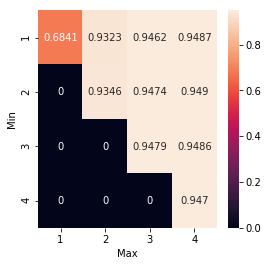

In [11]:
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(results, annot=True, fmt='.4g', xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.ylabel('Min')
plt.xlabel('Max')
plt.show()

Based on this, we will choose the range (2, 4).
 
Let's calculate the features for our train set and look at the most frequent n-grams:

In [12]:
count_vectorizer, _, tfidf_features = get_tfidf_features(train_dataset['string'], ngrams=(2, 4))
tfidf_feature_names = count_vectorizer.get_feature_names()
print('Number of features: {}'.format(len(tfidf_feature_names)))

occurrences = count_vectorizer.fit_transform(train_dataset['string']).toarray().sum(axis=0)
indices = np.argsort(occurrences)[::-1]
tfidf_feature_names = np.array(tfidf_feature_names)[indices]
occurrences = np.array(occurrences)[indices]
print('\n'.join(['{}: {}'.format(p[0], p[1]) for p in list(zip(tfidf_feature_names, occurrences))[:50]]))

Number of features: 17902
capword capword: 185027
uclett dot: 141123
lcword lcword: 132448
capword comma: 116388
capword lcword: 112750
lcword capword: 101639
dot capword: 98796
lcword lcword lcword: 84659
comma uclett: 77403
capword lcword capword: 75287
comma uclett dot: 75069
capword comma uclett: 64628
capword comma uclett dot: 64016
lcword lcword lcword lcword: 62713
comma capword: 62005
capword capword capword: 56618
capword dot: 54092
lcword capword capword: 51723
uclett dot capword: 47354
capword capword lcword: 46169
num dash: 40640
capword lcword capword capword: 40136
dash num: 39616
dot uclett: 39335
uclett dot uclett: 37272
num dash num: 37116
dot uclett dot: 37090
capword capword lcword capword: 36953
dot capword comma: 36841
uclett dot uclett dot: 36383
uclett dot capword comma: 34318
comma num: 31710
lcword dot: 31124
dot end: 30634
start capword: 28744
num dot: 28659
capword capword dot: 28503
num lpar: 28310
year rpar: 27727
num comma: 27097
lpar year: 26723
lpar year

We can see all types of ngrams. In most cases we can guess where they came from, eg. "lcword lcword lcword lcword" is typically a fragment of the title, and "uclett dot capword comma" looks like a fragment from the authors' list.

We can also check which features are the most correlated with the styles. We will use chi-squared statistic for this:

In [13]:
for style in STYLES:
    print()
    print('Style: {}'.format(style))
    features_chi2 = chi2(tfidf_features, train_dataset['style'] == style)[0]
    indices = np.argsort(features_chi2)
    feature_names = np.array(count_vectorizer.get_feature_names())[indices]
    bigrams = [v for v in feature_names if len(v.split(' '))  == 2]
    trigrams = [v for v in feature_names if len(v.split(' '))  == 3]
    fourgrams = [v for v in feature_names if len(v.split(' '))  == 4]
    print('Most correlated bigrams: {}'.format('|'.join(bigrams[-5:])))
    print('Most correlated trigrams: {}'.format('|'.join(trigrams[-5:])))
    print('Most correlated fourgrams: {}'.format('|'.join(fourgrams[-5:])))


Style: acm-sig-proceedings
Most correlated bigrams: dot lcword|dot year|rbracket year|rpar comma|rbracket capword
Most correlated trigrams: uclett dot year|num rbracket capword|rpar comma num|rbracket capword comma|year rpar comma
Most correlated fourgrams: num rbracket capword comma|dot year dot capword|rbracket capword comma uclett|lpar year rpar comma|year rpar comma num

Style: american-chemical-society
Most correlated bigrams: year comma|capword year|start lpar|semicolon capword|dot semicolon
Most correlated trigrams: start lpar num|comma num comma|semicolon capword comma|dot semicolon capword|uclett dot semicolon
Most correlated fourgrams: comma uclett dot semicolon|year comma num comma|dot semicolon capword comma|semicolon capword comma uclett|uclett dot semicolon capword

Style: american-chemical-society-with-titles
Most correlated bigrams: year comma|capword year|start lpar|semicolon capword|dot semicolon
Most correlated trigrams: start lpar num|comma num comma|semicolon capw

So far we used all n-grams present in the training set. Some of them are very rare and don't provide a lot of information for the training algorithm. Let's try using only n most frequent ngrams for varying values of n.

In [14]:
nfeatures_results = []
nfeatures_values = range(100, 5100, 100)
for n in nfeatures_values:
    accuracies, _ = evaluate_cv(train_dataset, LogisticRegression(random_state=0), feature_fun=get_tfidf_features,
                                nfeatures=n, ngrams=(2, 4))
    nfeatures_results.append(mean(accuracies))
    print('Accuracy for {} features: {}'.format(n, mean(accuracies)))

Accuracy for 100 features: 0.8932549440652052
Accuracy for 200 features: 0.9161741060473951
Accuracy for 300 features: 0.9299334765809008
Accuracy for 400 features: 0.9353969173632867
Accuracy for 500 features: 0.9373859985161394
Accuracy for 600 features: 0.9383482446219757
Accuracy for 700 features: 0.9399277700992988
Accuracy for 800 features: 0.9409769253128871
Accuracy for 900 features: 0.9420719284221821
Accuracy for 1000 features: 0.9427779273873068
Accuracy for 1100 features: 0.942883469794985
Accuracy for 1200 features: 0.943425674481975
Accuracy for 1300 features: 0.9440464487428002
Accuracy for 1400 features: 0.9446950783824073
Accuracy for 1500 features: 0.9454188255998915
Accuracy for 1600 features: 0.9453748723696622
Accuracy for 1700 features: 0.9457600609696106
Accuracy for 1800 features: 0.9461001656847915
Accuracy for 1900 features: 0.9462293775019801
Accuracy for 2000 features: 0.946488869056713
Accuracy for 2100 features: 0.9464881669237655
Accuracy for 2200 feature

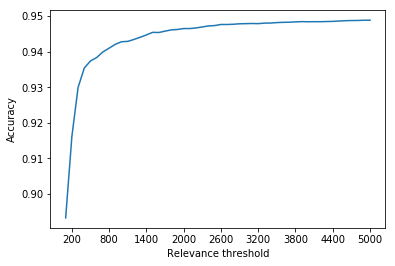

In [15]:
plt.plot(nfeatures_values, nfeatures_results)
plt.xticks(list(range(200, 5100, 600)))
plt.xlabel('Relevance threshold')
plt.ylabel('Accuracy')
plt.show()

It seems that the more features we have the better.

Choosing the most frequent features might not be optimal. Some frequent features will be useless because they don't provide any information about the target style. We can perform feature selection to choose a number of most useful features.

By passing *feature_selector* we make sure the best features are selected in the training phase. In this case, the selection is done using feature importance scores from Random Forest.

Similarly as before, we will test this with varying number of chosen features:

In [16]:
nfeatures_results_rf = []
nfeatures_values = range(100, 5100, 100)
for n in nfeatures_values:
    accuracies, _ = evaluate_cv(train_dataset, LogisticRegression(random_state=0),
                                feature_fun=get_tfidf_features, feature_selector=select_features_rf,
                                nfeatures=n, ngrams=(2, 4))
    nfeatures_results_rf.append(mean(accuracies))
    print('Accuracy for {} features: {}'.format(n, mean(accuracies)))

Accuracy for 100 features: 0.8427930161185753
Accuracy for 200 features: 0.9098613834939718
Accuracy for 300 features: 0.9292671074463225
Accuracy for 400 features: 0.9347081128076277
Accuracy for 500 features: 0.9379060464959171
Accuracy for 600 features: 0.9395472316549397
Accuracy for 700 features: 0.9405146481525951
Accuracy for 800 features: 0.9404297619549316
Accuracy for 900 features: 0.9410883641243749
Accuracy for 1000 features: 0.9411513576186056
Accuracy for 1100 features: 0.9415389347871161
Accuracy for 1200 features: 0.9416956495896103
Accuracy for 1300 features: 0.9417805784838041
Accuracy for 1400 features: 0.9422297046697184
Accuracy for 1500 features: 0.9424002053161804
Accuracy for 1600 features: 0.9425917618845578
Accuracy for 1700 features: 0.9426952916831054
Accuracy for 1800 features: 0.9428250425165134
Accuracy for 1900 features: 0.9431035602243957
Accuracy for 2000 features: 0.9432544944632166
Accuracy for 2100 features: 0.9431724997556918
Accuracy for 2200 feat

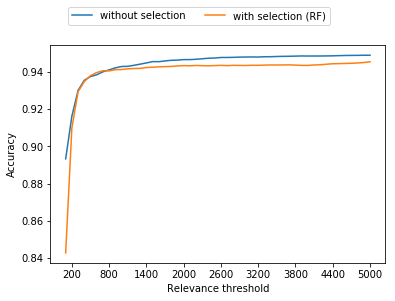

In [17]:
plt.plot(nfeatures_values, nfeatures_results)
plt.plot(nfeatures_values, nfeatures_results_rf)
plt.legend(['without selection', 'with selection (RF)'], bbox_to_anchor=(0.85, 1.2), ncol=3)
plt.xticks(list(range(200, 5100, 600)))
plt.xlabel('Relevance threshold')
plt.ylabel('Accuracy')
plt.show()

We can see that at first RF selection results in slightly better performance, but as we increase the number of features, no selection outperforms RF-based selection.

We will also try a simpler selection method, based on chi-squared correlations:

In [18]:
nfeatures_results_chi2 = []
nfeatures_values = range(100, 5100, 100)
for n in nfeatures_values:
    accuracies, _ = evaluate_cv(train_dataset, LogisticRegression(random_state=0),
                                feature_fun=get_tfidf_features, feature_selector=select_features_chi2,
                                nfeatures=n, ngrams=(2, 4))
    nfeatures_results_chi2.append(mean(accuracies))
    print('Accuracy for {} features: {}'.format(n, mean(accuracies)))

Accuracy for 100 features: 0.8236476784649813
Accuracy for 200 features: 0.857281293955016
Accuracy for 300 features: 0.8841845000572424
Accuracy for 400 features: 0.8913763782362153
Accuracy for 500 features: 0.9038922241544445
Accuracy for 600 features: 0.9079956992105075
Accuracy for 700 features: 0.9349582797297117
Accuracy for 800 features: 0.9364197381670085
Accuracy for 900 features: 0.9392762345512089
Accuracy for 1000 features: 0.9425956666668742
Accuracy for 1100 features: 0.9436451304238771
Accuracy for 1200 features: 0.9444345354856615
Accuracy for 1300 features: 0.9451254044525969
Accuracy for 1400 features: 0.9454647868016103
Accuracy for 1500 features: 0.9461050656587183
Accuracy for 1600 features: 0.9466437313598538
Accuracy for 1700 features: 0.9466652095926079
Accuracy for 1800 features: 0.9470491926766201
Accuracy for 1900 features: 0.9466226316987034
Accuracy for 2000 features: 0.9466642905515545
Accuracy for 2100 features: 0.9468990216052446
Accuracy for 2200 featu

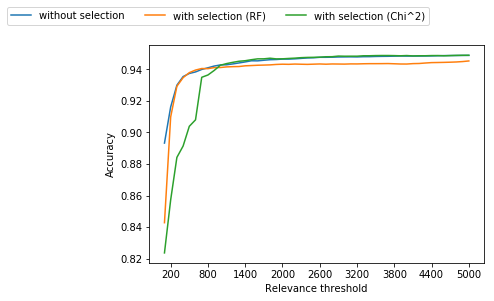

In [19]:
plt.plot(nfeatures_values, nfeatures_results)
plt.plot(nfeatures_values, nfeatures_results_rf)
plt.plot(nfeatures_values, nfeatures_results_chi2)
plt.legend(['without selection', 'with selection (RF)', 'with selection (Chi^2)'], bbox_to_anchor=(0.85, 1.2), ncol=3)
plt.xticks(list(range(200, 5100, 600)))
plt.xlabel('Relevance threshold')
plt.ylabel('Accuracy')
plt.show()

The best accuracy was given by chi-squared selection with 5000 features. We will use that from now on:

In [20]:
accuracies, _ = evaluate_cv(train_dataset, LogisticRegression(random_state=0),
                            feature_fun=get_tfidf_features, feature_selector=select_features_chi2,
                            nfeatures=5000, ngrams=(2, 4))
print('Fold accuracies: {}'.format(accuracies))
print('Mean accuracy: {}'.format(mean(accuracies)))

Fold accuracies: [0.9504485262708244, 0.9504341136388614, 0.9470455279302551, 0.9494358100915478, 0.9472964443509363]
Mean accuracy: 0.948932084456485


Let's also add one more feature (string length) to our feature representation.

In [21]:
accuracies, dataset_results_cv = evaluate_cv(train_dataset, LogisticRegression(random_state=0),
                                             feature_fun=get_features, feature_selector=select_features_chi2,
                                             nfeatures=5000, ngrams=(2, 4))
print('Fold accuracies: {}'.format(accuracies))
print('Mean accuracy: {}'.format(mean(accuracies)))

Fold accuracies: [0.950982486117044, 0.9515331355093967, 0.9463997416855021, 0.9494358100915478, 0.9487691984010099]
Mean accuracy: 0.9494240743609


Let's see the confusion matrix:

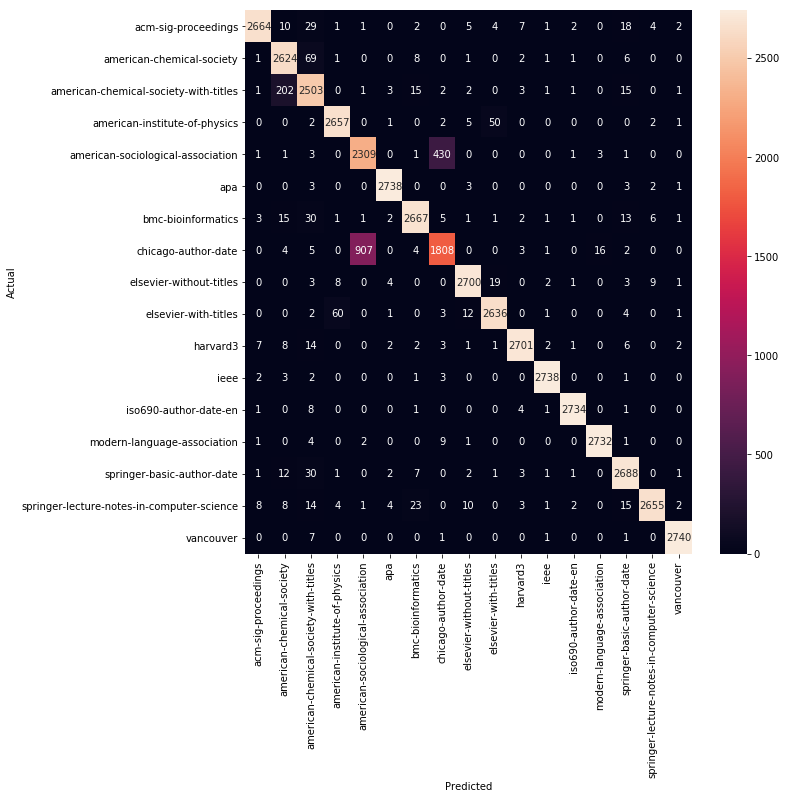

In [22]:
matrix = confusion_matrix(dataset_results_cv['style_true'], dataset_results_cv['style_pred'])

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=STYLES, yticklabels=STYLES)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Everything looks pretty good apart from the pair (chicago-author-date, american-sociological-association), which seem to be confused a lot by the classifier.

This function will show the reference string pairs from the two given  styles for all DOI that were mislabelled.

In [23]:
def get_diff(actual, predicted):
    diff_df = dataset_results_cv.loc[dataset_results_cv['style_true'] == actual]
    diff_dois = diff_df.loc[diff_df['style_pred'] == predicted]['doi']
    diff_df = dataset_results_cv.loc[dataset_results_cv['doi'].isin(diff_dois)]
    diff_df = diff_df.loc[diff_df['style_true'].isin([actual, predicted])].sort_values(by='doi')
    strings = [re.sub('^\(1\)', '', re.sub('^\[1\]', '', re.sub('^1', '', re.sub('\.$', '', s)))).strip()
               for s in diff_df['string']]
    strings_0 = [s for i, s in enumerate(strings) if i%2 == 0]
    strings_1 = [s for i, s in enumerate(strings) if i%2 == 1]
    return list(zip(strings_0, strings_1))

In [24]:
get_diff('chicago-author-date', 'american-sociological-association')

[('Runne, Uee. 1977. “Cutaneous Neural Proliferation in Highly Pruritic Lesions of Chronic Prurigo.” Archives of Dermatology 113(6):787',
  'Runne, Uee. 1977. “Cutaneous Neural Proliferation in Highly Pruritic Lesions of Chronic Prurigo.” Archives of Dermatology 113 (6) : 787'),
 ('Silver, Bruce. 1979. “Double Contrast Gastrointestinal Radiology With Endoscopic Correlation.” JAMA: The Journal of the American Medical Association 242(17):1917',
  'Silver, Bruce. 1979. “Double Contrast Gastrointestinal Radiology With Endoscopic Correlation.” JAMA: The Journal of the American Medical Association 242 (17) : 1917'),
 ('Greenfield, Sheldon. 1992. “Specialists or Generalists? The Medical Outcomes Study-Reply.” JAMA: The Journal of the American Medical Association 268(12):1538',
  'Greenfield, Sheldon. 1992. “Specialists or Generalists? The Medical Outcomes Study-Reply.” JAMA: The Journal of the American Medical Association 268 (12) : 1538'),
 ('Kaiser, Harry M. 2003. “Distribution of Benefits 

In a lot of cases the reference strings are very similar, or identical. No wonder the classifier has problems differentiating between the styles.

Finally, let's test a few learning algorithms using previously chosen parameters:

In [25]:
algo_results = []
for name, algo in [('Naive Bayes', MultinomialNB()),
                   ('Logistic Regression', LogisticRegression(random_state=5)),
                   ('Linear SVC', LinearSVC(random_state=5)),
                   ('Random Forest', RandomForestClassifier(n_estimators=200, max_depth=3, random_state=5))]:
    accuracies, _ = evaluate_cv(train_dataset, algo, feature_fun=get_features, feature_selector=select_features_chi2,
                                nfeatures=5000, ngrams=(2, 4))
    algo_results.extend([(name, fold, accuracy) for fold, accuracy in enumerate(accuracies)])
    print('Accuracy for {} algorithm {}'.format(name, mean(accuracies)))

Accuracy for Naive Bayes algorithm 0.9277189766219226
Accuracy for Logistic Regression algorithm 0.9494240743609
Accuracy for Linear SVC algorithm 0.912820283271956
Accuracy for Random Forest algorithm 0.887854822215188


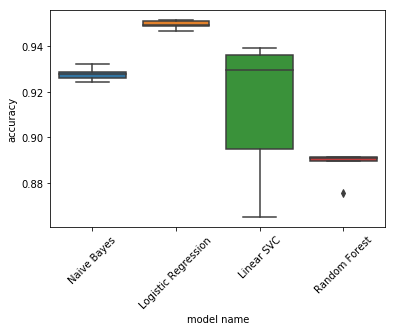

In [26]:
cv_df = pd.DataFrame(algo_results, columns=['model name', 'fold', 'accuracy'])
ax = sns.boxplot(x='model name', y='accuracy', data=cv_df)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

It seems logistic regression results in the best accuracy averaged over the folds. Also the variance of the results in this case is small.

Finally, let's fit the model to the entire train set and evaluate on the main test set:

In [27]:
count_vectorizer, tfidf_transformer, train_features = get_features(train_dataset['string'], nfeatures=5000,
                                                                   feature_selector=select_features_chi2,
                                                                   ngrams=(2, 4))
_, _, test_features = get_features(test_dataset['string'], count_vectorizer=count_vectorizer,
                                   tfidf_transformer=tfidf_transformer)
model = LogisticRegression(random_state=0).fit(train_features, train_dataset['style'])
prediction = model.predict(test_features)
print('The final accuracy: {}'.format(accuracy_score(test_dataset['style'], prediction)))

The final accuracy: 0.9481200115395712


The final unbiased accuracy estimate is 94.8%.